<a href="https://colab.research.google.com/github/rnrrmr/image-classification/blob/main/weather_classification_160.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %cd /content/drive/MyDrive/weather-dataset
# !unzip -qq "/content/drive/MyDrive/weather-dataset/dataset.zip"

/content/drive/MyDrive/weather-dataset


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
# from sklearn.metrics import confusion_matrix, classification_report  # 얘들은 아직 안씀

이미지 크기
(180, 180) 사이즈로 조정?
160 160


In [ ]:
# 램 과도한 사용으로 인한 코드 변경
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil

datagen = ImageDataGenerator(
    # rescale=1.0/225.0,  # 이미지 값을 [0, 1] 범위로 정규화
    samplewise_center=True,  # set each sample mean to 0
    rotation_range=60,  # randomly rotate images in the range (degrees, 0 to 160)
    # zoom_range = 0.1, # Randomly zoom image
    width_shift_range=0.25,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.25,  # randomly shift images vertically (fraction of total height)
    # horizontal_flip=True,  # randomly flip images
    # vertical_flip=True,# flip vertically
    validation_split=0.2
)

# 데이터 디렉토리 경로
data_dir = "/content/drive/MyDrive/weather-dataset/dataset"
batch_size = 32

# 테스트 데이터 폴더 생성
test_data_dir = "/content/drive/MyDrive/weather-dataset/test_data"
os.makedirs(test_data_dir, exist_ok=True)

# 테스트 데이터로 사용할 이미지를 해당 폴더로 복사 또는 이동
class_folders = os.listdir(data_dir)
for class_folder in class_folders:
    class_path = os.path.join(data_dir, class_folder)
    images = os.listdir(class_path)

    # 테스트 데이터로 사용할 이미지를 선택하여 복사 또는 이동
    # 예: 데이터 중 10%를 테스트 데이터로 사용
    num_test_images = int(0.1 * len(images))
    test_images = images[:num_test_images]

    # 테스트 데이터 폴더로 이미지 복사 또는 이동
    for img in test_images:
        src = os.path.join(class_path, img)
        dest = os.path.join(test_data_dir, class_folder, img)
        shutil.copy(src, dest)

# 학습용 데이터 로드
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(160, 160),  # 이미지 크기를 조정
    batch_size=batch_size,
    class_mode='categorical',  # 다중 클래스 분류를 위한 설정
    subset='training'  # 학습 데이터로 설정
)
# 검증용 데이터 로드
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(160, 160),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # 검증 데이터로 설정
)

# 테스트용 데이터 로드
# test_data_dir = "/content/drive/MyDrive/weather-dataset/weather_sample"
# test_generator = datagen.flow_from_directory(
#     test_data_dir,
#     target_size=(160, 160),
#     batch_size=batch_size,
#     class_mode='categorical'
# )

Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.


In [ ]:
class_labels = os.listdir(data_dir)
print(class_labels)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [ ]:
# 모델 정의
model = keras.Sequential()

# 입력 레이어 (224x224 크기의 RGB 이미지)
model.add(keras.layers.Input(shape=(160, 160, 3))) # 채널(색상) 수가 3(RGB)

# 컨볼루션 레이어 (첫 번째 블록)
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')) # padding 'same'으로 설정하면 입력 이미지와 출력 이미지의 크기를 동일하게 유지하려고 시도
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')) # 이미지 가장자리에 있는 정보를 보존하는 데 도움
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')) # stride 높이와 너비에 따른 컨볼루션의 보폭을 지정하는 정수 또는 2개의 정수로 구성된 튜플

# 컨볼루션 레이어 (두 번째 블록)
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))  # 맥스 풀링 레이어는 특성 맵을 다운샘플링하여 공간 차원을 줄입니다. 이 과정은 이미지 크기를 반으로 줄입니다

# 컨볼루션 레이어 (세 번째 블록)
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))  # VGG16 아키텍처의 특징, 블록마다 컨볼루션 레이어로 특징을 추출하고 맥스 풀링 레이어로 공간 크기를 줄여 깊은 특성을 학습

# 컨볼루션 레이어 (네 번째 블록)
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

# 컨볼루션 레이어 (다섯 번째 블록)
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

# 글로벌 평균 풀링 레이어
model.add(keras.layers.GlobalAveragePooling2D())

# 완전 연결 레이어 (분류 레이어)
model.add(keras.layers.Dense(11, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 구조 요약
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 40, 40, 256)      

이 모델은 VGG16 아키텍처를 기반으로 한 컨볼루션 신경망(Convolutional Neural Network, CNN) 모델로, 주로 이미지 분류 작업을 위한 것으로 추정됩니다. 여러 부분으로 나눠진 이 모델을 살펴보겠습니다.

1. `model.add(keras.layers.GlobalAveragePooling2D())`: 이 부분은 모델의 뒷부분에 위치한 글로벌 평균 풀링 레이어를 추가하는 부분입니다. 글로벌 평균 풀링 레이어는 특정 특성 맵의 공간 차원을 축소시키는 데 사용됩니다. 이것은 고해상도의 특성 맵을 작은 고정 크기의 벡터로 변환합니다. 일반적으로 CNN의 출력 특성 맵을 1차원 벡터로 변환하여 완전 연결 레이어에 연결하기 위해 사용됩니다.

3. `model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1'))`: 이 부분은 첫 번째 컨볼루션 블록을 정의하는 부분입니다. 여기서 `(3, 3)`은 3x3 크기의 필터를 사용하고, `64`는 이 필터의 개수입니다. 'relu' 활성화 함수를 사용하며 'same' 패딩을 사용하여 입력과 출력의 크기를 동일하게 유지합니다. 이 레이어의 이름은 'block1_conv1'로 지정됩니다.

4. `model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))`: 두 번째 컨볼루션 레이어로, 첫 번째 레이어와 같은 구성을 가지고 있습니다. 레이어 이름은 'block1_conv2'입니다.

5. `model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))`: 이 부분은 첫 번째 컨볼루션 블록의 맥스 풀링 레이어를 정의합니다. `(2, 2)` 크기의 풀링 윈도우를 사용하여 입력 이미지의 크기를 줄이고, `strides=(2, 2)`는 풀링 연산 시 이동 거리를 나타냅니다. 이러한 맥스 풀링 레이어는 특성 맵을 다운샘플링하여 공간 차원을 줄입니다. 이 과정은 이미지 크기를 반으로 줄입니다.

6. 마찬가지로 두 번째, 세 번째, 네 번째, 다섯 번째 블록에 대한 컨볼루션 레이어와 맥스 풀링 레이어가 정의되어 있습니다. 이것은 VGG16 아키텍처의 특징입니다. 블록마다 컨볼루션 레이어로 특징을 추출하고 맥스 풀링 레이어로 공간 크기를 줄여 깊은 특성을 학습합니다.

이 모델의 주요 특징은 이미지 분류를 위한 딥러닝 모델로, VGG16 아키텍처를 따르며 컨볼루션 레이어와 맥스 풀링 레이어로 구성되어 있습니다. 이 모델은 224x224 크기의 RGB 이미지를 입력으로 받고, 11개의 클래스에 대한 확률을 출력합니다. 각 컨볼루션 블록은 점차적으로 더 깊어지며, 특징 추출을 위해 사용되는 필터 수도 늘어납니다.

In [ ]:
model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/30
172/172 [==============================] - 125s 595ms/step - loss: 5.6625 - accuracy: 0.2092 - val_loss: 1.9745 - val_accuracy: 0.2922
Epoch 2/30
172/172 [==============================] - 99s 573ms/step - loss: 1.9071 - accuracy: 0.3098 - val_loss: 1.7461 - val_accuracy: 0.3484
Epoch 3/30
172/172 [==============================] - 99s 573ms/step - loss: 1.6686 - accuracy: 0.3971 - val_loss: 1.5917 - val_accuracy: 0.4266
Epoch 4/30
172/172 [==============================] - 94s 543ms/step - loss: 1.4823 - accuracy: 0.4691 - val_loss: 1.5434 - val_accuracy: 0.4449
Epoch 5/30
172/172 [==============================] - 99s 572ms/step - loss: 1.4033 - accuracy: 0.4992 - val_loss: 1.5588 - val_accuracy: 0.4529
Epoch 6/30
172/172 [==============================] - 102s 592ms/step - loss: 1.3349 - accuracy: 0.5254 - val_loss: 1.3022 - val_accuracy: 0.5471
Epoch 7/30
172/172 [==============================] - 95s 552ms/step - loss: 1.2788 - accuracy: 0.5436 - val_loss: 1.3630 - val_

두 번째 에포크에서 학습 데이터에 대한 손실값은 약 1.4793이고, 정확도는 약 45.70%로 개선

두 번째 에포크에서 검증 데이터에 대한 손실값은 약 1.3649이고, 검증 데이터에 대한 정확도는 약 50.66%로 개선

> 첫번째 에포크에서 많은 시간이 소요되는 이유

데이터 증강 (Data Augmentation): 학습 데이터에 다양성을 부여. 이미지 데이터의 경우, 회전, 이동, 확대/축소, 뒤집기 등의 변환을 적용하여 학습 데이터를 더 다양하게 만듦. 첫 번째 에포크에서는 데이터 증강 작업이 시작되기 때문에 추가적인 시간이 소요될 수 있습니다.

데이터 불러오기: 학습 데이터셋의 초기 로딩과 데이터 파이프라인 설정에는 시간이 소요될 수 있습니다. 첫 번째 에포크에서는 데이터를 처음 로드하고 파이프라인을 설정하는 초기화 단계가 발생하기 때문입니다.


배치 생성: 데이터 파이프라인은 배치 단위로 데이터를 생성하여 모델에 공급합니다. 이 때 첫 번째 배치를 생성하고 전달하는 데 시간이 소요됩니다. 이후 에포크에서는 배치 생성 및 전달이 더 빨라질 수 있습니다.

In [ ]:
# history = model.fit(
#     train_generator,
#     validation_data=validation_generator,
#     epochs=30,  # 에포크 값을 10으로 변경
#     initial_epoch=5,  # 이전 학습에서 마지막으로 진행한 에포크 번호 (5 에포크부터 이어서 학습)
#     callbacks=my_callbacks,
#     verbose=1
# )

Epoch 6/10
134/134 [==============================] - 75s 557ms/step - loss: 1.1755 - accuracy: 0.5656 - val_loss: 1.1163 - val_accuracy: 0.5713
Epoch 7/10
134/134 [==============================] - 71s 531ms/step - loss: 1.0888 - accuracy: 0.5957 - val_loss: 1.1250 - val_accuracy: 0.5994
Epoch 8/10
134/134 [==============================] - 70s 524ms/step - loss: 1.0678 - accuracy: 0.6072 - val_loss: 1.0590 - val_accuracy: 0.6323
Epoch 9/10
134/134 [==============================] - 72s 536ms/step - loss: 1.0167 - accuracy: 0.6308 - val_loss: 1.0177 - val_accuracy: 0.6435
Epoch 10/10
134/134 [==============================] - 71s 528ms/step - loss: 1.0099 - accuracy: 0.6259 - val_loss: 1.0075 - val_accuracy: 0.6604


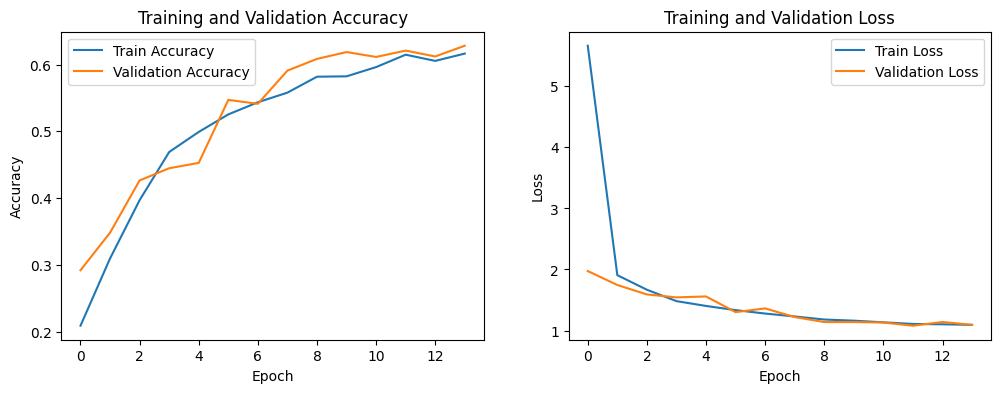

In [ ]:
# 학습 과정 시각화
plt.figure(figsize=(12, 4))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실값 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    # 이미지 불러오기 및 전처리
    image = image_utils.load_img(image_path, target_size=(160, 160))
    image = image_utils.img_to_array(image)
    image = image.reshape(1, 160, 160, 3)
    image = preprocess_input(image)

    # 모델로 예측 수행
    preds = model.predict(image)

    # 클래스 인덱스와 예측 확률 추출
    predicted_class_index = np.argmax(preds)

    # 클래스명 가져오기
    predicted_class = class_labels[predicted_class_index]

    # 이미지 시각화
    show_image(image_path)

    # 예측 결과 출력
    print(f"Predicted class index: {predicted_class_index}")
    print(f"Predicted class name: {predicted_class}")
    print(f"Probability: {preds[0][predicted_class_index]*100:.3f}%")

    return preds


1/1 [==============================] - 0s 31ms/step
Predicted class index: 0
Predicted class name: dew
Probability: 63.892%


array([[6.3891792e-01, 1.8294562e-04, 7.0058897e-02, 5.0821651e-02,
        1.8008068e-01, 5.5517961e-04, 4.8439585e-02, 8.8595143e-03,
        2.4318423e-04, 1.3996667e-03, 4.4070999e-04]], dtype=float32)

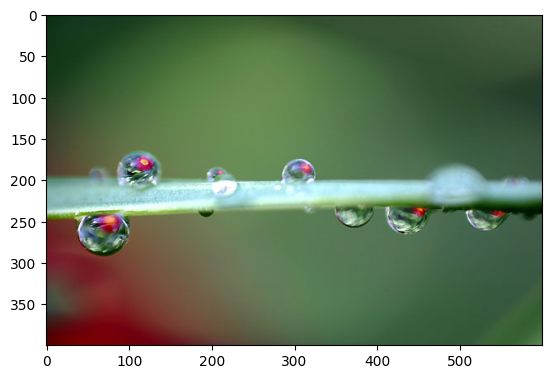

In [ ]:
make_predictions("/content/drive/MyDrive/weather-dataset/weather_sample/image2.jpg")

1/1 [==============================] - 0s 85ms/step
Predicted class index: 1
Predicted class name: fogsmog
Probability: 43.19%


array([[3.6648537e-03, 4.3188173e-01, 1.3830808e-03, 8.6078572e-04,
        2.5257058e-04, 2.9781831e-02, 4.0117563e-03, 1.2361118e-01,
        3.5128414e-03, 3.9307970e-01, 7.9596005e-03]], dtype=float32)

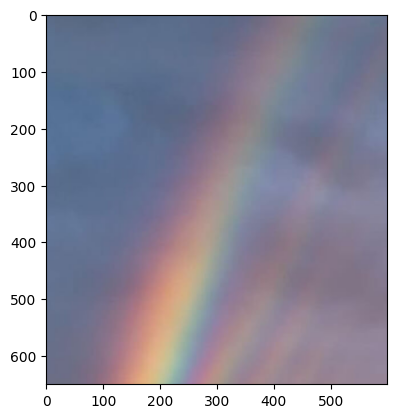

In [ ]:
make_predictions("/content/drive/MyDrive/weather-dataset/weather_sample/image8.jpg")

In [ ]:
# 테스트용 데이터 로드
test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # 이미지 값을 [0, 1] 범위로 정규화

test_data_dir = "/content/drive/MyDrive/weather-dataset/test_data"

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(160, 160),  # 이미지 크기를 조정 (학습과 동일한 크기로 설정)
    batch_size=batch_size,  # 배치 크기는 학습과 동일하게 설정
    class_mode='categorical',  # 다중 클래스 분류
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print("Test accuracy:", test_accuracy)


Found 1064 images belonging to 11 classes.
34/34 [==============================] - 52s 2s/step - loss: 8.1876 - accuracy: 0.1391
Test accuracy: 0.13909775018692017


정규화 이유

1. **수렴 속도 향상**: 입력 이미지의 픽셀 값 범위가 클 경우, 모델의 가중치 업데이트가 불안정해질 수 있습니다. 정규화를 통해 입력 값의 범위를 [0, 1]로 축소하면 가중치 업데이트가 더 안정적으로 이루어질 가능성이 높아집니다.

2. **그래디언트 안정성**: 정규화된 입력은 더 작은 그래디언트 값을 가지므로 그래디언트 손실(gradient vanishing)을 방지합니다. 이로 인해 신경망의 깊은 층에서 그래디언트가 소멸하는 현상을 완화시킬 수 있습니다.

3. **일반화 능력 향상**: 정규화는 모델의 일반화 능력을 향상시킵니다. 더 작은 입력 값 범위는 모델이 데이터의 세부 사항을 더 잘 학습하고 새로운 데이터에 대한 예측 능력을 향상시킵니다.

모델평가를 진행했으나 Test Accuracy가 0.139정도로 낮게 나오기 때문에 사전 훈련된 모델을 사용해서 전이학습을 진행하려함

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# 1. 사전 훈련된 모델 선택
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

# 2. 모델 아키텍처 구성
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(11, activation='softmax'))  # 새로운 작업에 맞는 분류 레이어 추가

# 3. 가중치 초기화 (사전 훈련된 가중치 사용)

# 4. 학습 데이터 준비
# train_generator와 validation_generator를 사용하여 데이터 로드

# 5. 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
# model.complie(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 6. 모델 학습
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    verbose=1
)

# 7. 모델 평가
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test accuracy:", test_accuracy)

Epoch 1/30
172/172 [==============================] - 108s 586ms/step - loss: 2.7879 - accuracy: 0.2301 - val_loss: 1.8557 - val_accuracy: 0.3382
Epoch 2/30
172/172 [==============================] - 104s 598ms/step - loss: 1.6831 - accuracy: 0.3945 - val_loss: 1.6014 - val_accuracy: 0.4112
Epoch 3/30
172/172 [==============================] - 94s 545ms/step - loss: 1.4967 - accuracy: 0.4633 - val_loss: 1.5329 - val_accuracy: 0.4390
Epoch 4/30
172/172 [==============================] - 96s 558ms/step - loss: 1.3809 - accuracy: 0.5023 - val_loss: 1.4534 - val_accuracy: 0.5128
Epoch 5/30
172/172 [==============================] - 102s 592ms/step - loss: 1.2867 - accuracy: 0.5350 - val_loss: 1.2876 - val_accuracy: 0.5544
Epoch 6/30
172/172 [==============================] - 97s 565ms/step - loss: 1.2059 - accuracy: 0.5660 - val_loss: 1.1786 - val_accuracy: 0.5771
Epoch 7/30
172/172 [==============================] - 94s 544ms/step - loss: 1.1904 - accuracy: 0.5766 - val_loss: 1.2846 - val

KeyboardInterrupt: ignored

Epoch 4/30
172/172 [==============================] - 94s 543ms/step - loss: 1.4823 - accuracy: 0.4691 - val_loss: 1.5434 - val_accuracy: 0.4449